# AIRL with TransactionsGraphEnvironment v2

In [56]:
import ast
import pickle
import gymnasium as gym
import mlflow
import numpy as np
import pandas as pd
import torch
from imitation.algorithms.adversarial.airl import AIRL
from imitation.data.rollout import flatten_trajectories
from imitation.data.types import Trajectory
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.rewards.reward_nets import BasicShapedRewardNet
from imitation.util import logger
from imitation.util.networks import RunningNorm
from imitation.util.util import make_vec_env
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecCheckNan
from stable_baselines3.ppo import MlpPolicy

import graph_reinforcement_learning_using_blockchain_data as grl
from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()
mlflow.set_tracking_uri(uri=config.MLFLOW_TRACKING_URI)

In [3]:
RNG = np.random.default_rng(seed=42)

## Dataset 

In [4]:
df_emb = pd.read_csv(config.FLASHBOTS_Q2_DATA_DIR / "state_embeddings_dgi_128.csv")
df_class0 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class0.csv")
df_class1 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class1.csv")
df_eth_balances_class1 = pd.read_csv(config.RAW_DATA_DIR / "eth_balances_class1.csv")
df_eth_balances_class0 = pd.read_csv(config.RAW_DATA_DIR / "eth_balances_class0.csv")

with open(config.FLASHBOTS_Q2_DATA_DIR / "train_accounts.pkl", "rb") as f:
    train_accounts = pickle.load(f)

with open(config.FLASHBOTS_Q2_DATA_DIR / "test_accounts.pkl", "rb") as f:
    test_accounts = pickle.load(f)

In [5]:
print(df_class0.columns)
print(df_eth_balances_class0.columns)

Index(['block_number', 'transaction_hash', 'blockHash', 'blockNumber',
       'logsBloom', 'gasUsed', 'contractAddress', 'cumulativeGasUsed',
       'transactionIndex', 'from', 'to', 'type', 'effectiveGasPrice', 'logs',
       'status'],
      dtype='object')
Index(['account', 'block_number', 'balance'], dtype='object')


In [6]:
df_class0_with_eth_balances = df_class0.merge(
    df_eth_balances_class0,
    left_on=["from", "blockNumber"],
    right_on=["account", "block_number"],
    how="inner",
)
df_class1_with_eth_balances = df_class1.merge(
    df_eth_balances_class1,
    left_on=["from", "blockNumber"],
    right_on=["account", "block_number"],
    how="inner",
)

In [7]:
df_class0_multi_occ = df_class0_with_eth_balances[
    df_class0_with_eth_balances["from"].duplicated(keep=False)
]

In [8]:
df_emb["embeddings"] = df_emb["embeddings"].apply(
    lambda x: np.array(ast.literal_eval(x), dtype=np.float32)
)

In [9]:
df_class0_with_eth_balances["label"] = 0
df_class1_with_eth_balances["label"] = 1

In [10]:
df_receipts = pd.concat(
    [df_class0_with_eth_balances, df_class1_with_eth_balances], ignore_index=True
)
df_receipts.drop_duplicates("transaction_hash", inplace=True)
df = df_receipts.merge(df_emb, how="right", left_on="transaction_hash", right_on="transactionHash")

In [11]:
df.head()

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,created_at,account_address,profit_token_address,start_amount,end_amount,profit_amount,error,protocols,transactionHash,embeddings
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0071866573, 0.0, 0..."
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.007031055, 0.0, 0...."


In [12]:
df_median_gas_prices = pd.DataFrame(
    {
        "median_gas_price": df.groupby(["blockNumber"])["effectiveGasPrice"].median(),
        "std_gas_price": df.groupby(["blockNumber"])["effectiveGasPrice"].std(),
        "max_gas_price": df.groupby(["blockNumber"])["effectiveGasPrice"].max(),
        "min_gas_price": df.groupby(["blockNumber"])["effectiveGasPrice"].min(),
    }
)

df_with_median_gas_prices = df.merge(df_median_gas_prices, how="left", on="blockNumber")
df_with_median_gas_prices.head()

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,end_amount,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,std_gas_price,max_gas_price,min_gas_price
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.841278e+10,5.338623e+09,40046142239,27985774295
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.132425e+10,1.310671e+10,62912040686,29651658352
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.701599e+10,9.483538e+10,298140379626,44115991364
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0071866573, 0.0, 0...",3.997607e+10,2.216894e+10,72384430845,29976074199
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.007031055, 0.0, 0....",2.695208e+10,3.320303e+09,30915355327,22915355327


In [13]:
df_with_actions = df_with_median_gas_prices.copy()
df_with_actions["action"] = df_with_median_gas_prices.apply(
    lambda r: 1 if r["effectiveGasPrice"] > r["median_gas_price"] else 0, axis=1
)

In [14]:
df_with_actions["action"].mean()

0.24449359876667337

In [15]:
df_with_actions.head()

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,std_gas_price,max_gas_price,min_gas_price,action
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.841278e+10,5.338623e+09,40046142239,27985774295,1
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.132425e+10,1.310671e+10,62912040686,29651658352,1
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.701599e+10,9.483538e+10,298140379626,44115991364,1
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0071866573, 0.0, 0...",3.997607e+10,2.216894e+10,72384430845,29976074199,0
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.007031055, 0.0, 0....",2.695208e+10,3.320303e+09,30915355327,22915355327,1


In [16]:
df_with_actions.rename(columns={"balance": "eth_balance"}, inplace=True)
df_with_actions["eth_balance"] = df_with_actions["eth_balance"].astype("float64")
df_with_actions["median_gas_price"] = df_with_actions["median_gas_price"].astype("float64")
df_with_actions["std_gas_price"] = df_with_actions["std_gas_price"].astype("float64")
df_with_actions["from"] = df_with_actions["from"].astype("string")
df_with_actions["to"] = df_with_actions["to"].astype("string")
df_with_actions.head()

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,std_gas_price,max_gas_price,min_gas_price,action
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.841278e+10,5.338623e+09,40046142239,27985774295,1
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.132425e+10,1.310671e+10,62912040686,29651658352,1
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.701599e+10,9.483538e+10,298140379626,44115991364,1
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0071866573, 0.0, 0...",3.997607e+10,2.216894e+10,72384430845,29976074199,0
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.007031055, 0.0, 0....",2.695208e+10,3.320303e+09,30915355327,22915355327,1


In [17]:
df_with_actions[df_with_actions["std_gas_price"].isna() == True]

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,std_gas_price,max_gas_price,min_gas_price,action
63,16975107,0xd05a59ef18204af79ae9bf2a7ba722bca892055819c7...,0x8d8cd7dfa64a3867f12d472be895ee2a1b163d854a02...,16975107,0x00200000000000000000000080000000000008000000...,196537,NaN,685900,5,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,6855415086744551,NaN,"[""uniswap_v2""]",0xd05a59ef18204af79ae9bf2a7ba722bca892055819c7...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.442311e+10,NaN,34423111170,34423111170,0
65,16976564,0x5530313d0b0271506691e3732c517172d5bfa1b2ba3d...,0x458b66a35808bf44a7e332b9f9b326ca8660952ab40a...,16976564,0x00200000000000000000000080000000200000000000...,190691,NaN,1322470,7,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,7796163749018364,NaN,"[""uniswap_v2""]",0x5530313d0b0271506691e3732c517172d5bfa1b2ba3d...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.041179e+10,NaN,40411786608,40411786608,0
76,16979829,0xe47601937f0538ecc2a67c0a1b2481a1d339b52b2ef0...,0x4d1ebc8a72732a87fb083679233a06cf0a33ec984b35...,16979829,0x00200000000000000000000084000000200000000000...,158198,NaN,158198,0,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,24408839782523421,NaN,"[""uniswap_v2"",""uniswap_v3""]",0xe47601937f0538ecc2a67c0a1b2481a1d339b52b2ef0...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.532201e+11,NaN,153220129205,153220129205,0
98,16992014,0x23e05562df7784836aaf6c8235d2aca5501621e6aab2...,0x8794222099471416ba2721137ee0e0d60a149b2f2029...,16992014,0x00200000000000000000000080000200000000000000...,219788,NaN,219788,0,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,35168219119161781,NaN,"[""uniswap_v2"",""uniswap_v3""]",0x23e05562df7784836aaf6c8235d2aca5501621e6aab2...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.595249e+11,NaN,159524873969,159524873969,0
167,17240935,0x74e6628155b2f61c067a568235c952e3c1fa4aa22d76...,0xa658109201d2dcd46dcc9f5ad1c71d29d6942c44b1c4...,17240935,0x00000000040000000000000000000000000000000000...,210289,NaN,2954344,23,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,13097045417966494,NaN,"[""uniswap_v3""]",0x74e6628155b2f61c067a568235c952e3c1fa4aa22d76...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6.190800e+10,NaN,61907998723,61907998723,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149181,17296632,0x2f06cc7f885dd98fbf765ad57706fe505c5b63478928...,0x64522455567aa9a4209551fd938a1e31b448487ac157...,17296632,0x00200000000000000010000080000000000000000000...,178376,NaN,440031,1,0xffFf14106945bCB267B34711c416AA3085B8865F,...,22902832502491512,NaN,"[""uniswap_v2""]",0x2f06cc7f885dd98fbf765ad57706fe505c5b63478928...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.450291e+10,NaN,34502909809,34502909809,0
149182,17297932,0xd477617aaa93aad5aa5f5a2f880f3e934b70a91cd523...,0x493341206c063a7ba6c85137473b17f697ed72701c07...,17297932,0x00200000000000000010000080000000000000000000...,178388,NaN,440065,1,0xffFf14106945bCB267B34711c416AA3085B8865F,...,31467600199400760,NaN,"[""uniswap_v2""]",0xd477617aaa93aad5aa5f5a2f880f3e934b70a91cd523...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.928406e+10,NaN,29284056698,29284056698,0
149183,17298360,0xda0b7b1156a57ff85ef5c2e80f47d6fc0c89c6253fca...,0x21a1c5ae76e2cbff779f308288e1cf2273d999f978e1...,17298360,0x00200000000000000010000080000000000000000000...,178352,NaN,439975,1,0xffFf14106945bCB267B34711c416AA3085B8865F,...,38228015952142520,NaN,"[""uniswap_v2""]",0xda0b7b1156a57ff85ef5c2e80f47d6fc0c89c6253fca...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.959543e+10,NaN,29595427147,29595427147,0
149184,17298379,0x7755b8553cc9f2479e5cc48ebf18dd6f25fe038a668f...,0xa0171ad96bcd73eb6aa92c8da1e3a8629c1c067ea811...,17298379,0x00200000000000000010000080000000000000000000...,178364,NaN,1162669,7,0xffFf14106945bCB267

In [18]:
df_with_actions = df_with_actions.fillna({"std_gas_price": 0})

In [19]:
df_with_actions_0 = df_with_actions[df_with_actions["label"] == 0]
df_with_actions_1 = df_with_actions[df_with_actions["label"] == 1]

In [20]:
validation_accounts, test_accounts_excl_val = train_test_split(
    test_accounts, test_size=0.5, random_state=42
)

In [21]:
df_with_actions_0_train = df_with_actions_0[df_with_actions_0["from"].isin(train_accounts)]
df_with_actions_0_val = df_with_actions_0[df_with_actions_0["from"].isin(validation_accounts)]
df_with_actions_0_test = df_with_actions_0[df_with_actions_0["from"].isin(test_accounts_excl_val)]

In [22]:
df_with_actions_1_train = df_with_actions_1[df_with_actions_1["from"].isin(train_accounts)]
df_with_actions_1_val = df_with_actions_1[df_with_actions_1["from"].isin(validation_accounts)]
df_with_actions_1_test = df_with_actions_1[df_with_actions_1["from"].isin(test_accounts_excl_val)]

In [23]:
df_val = pd.concat([df_with_actions_0_val, df_with_actions_1_val])

## Creating trajectories

In [24]:
def extract_trajectories(df: pd.DataFrame):
    trajectories = []
    for account, group in df.groupby("from"):
        group = group.sort_values("blockNumber")
        obs_list = group["embeddings"].tolist() + [np.zeros(128, dtype=np.float32)]
        traj = {
            "obs": np.stack(obs_list),  # Convert list of arrays to a single numpy array
            "acts": np.array(group["action"].tolist()),
            "label": group["label"].iloc[0],
        }
        trajectories.append(traj)
    return trajectories


trajectories_1_train = extract_trajectories(df_with_actions_1_train)
trajectories_0_train = extract_trajectories(df_with_actions_0_train)
trajectories_1_test = extract_trajectories(df_with_actions_1_test)
trajectories_0_test = extract_trajectories(df_with_actions_0_test)
trajectories_val = extract_trajectories(df_val)

In [25]:
trajectories_1 = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_1_train
]
trajectories_0 = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_0_train
]
trajectories_val = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_val
]

trajectories_1 = flatten_trajectories(trajectories_1)
trajectories_0 = flatten_trajectories(trajectories_0)
trajectories_val = flatten_trajectories(trajectories_val)

In [26]:
trajectories_1_test = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_1_test
]
trajectories_0_test = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_0_test
]

trajectories_1_test = flatten_trajectories(trajectories_1_test)
trajectories_0_test = flatten_trajectories(trajectories_0_test)

## Setting up environments

In [27]:
ID0 = "gymnasium_env/TransactionGraphEnv0-v2"
gym.envs.register(
    id=ID0,
    entry_point=grl.TransactionGraphEnvV2,
    kwargs={"df": df_with_actions_0, "alpha": 0.9, "device": torch.device("mps"), "label": 0},
    max_episode_steps=300,
)

ID1 = "gymnasium_env/TransactionGraphEnv1-v2"
gym.envs.register(
    id=ID1,
    entry_point=grl.TransactionGraphEnvV2,
    kwargs={"df": df_with_actions_1, "alpha": 0.9, "device": torch.device("mps"), "label": 1},
    max_episode_steps=300,
)

In [28]:
gym.pprint_registry()

===== classic_control =====
Acrobot-v1             CartPole-v0            CartPole-v1
MountainCar-v0         MountainCarContinuous-v0 Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0     phys2d/CartPole-v1     phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3       BipedalWalkerHardcore-v3 CarRacing-v2
LunarLander-v2         LunarLanderContinuous-v2
===== toy_text =====
Blackjack-v1           CliffWalking-v0        FrozenLake-v1
FrozenLake8x8-v1       Taxi-v3
===== tabular =====
tabular/Blackjack-v0   tabular/CliffWalking-v0
===== mujoco =====
Ant-v2                 Ant-v3                 Ant-v4
HalfCheetah-v2         HalfCheetah-v3         HalfCheetah-v4
Hopper-v2              Hopper-v3              Hopper-v4
Humanoid-v2            Humanoid-v3            Humanoid-v4
HumanoidStandup-v2     HumanoidStandup-v4     InvertedDoublePendulum-v2
InvertedDoublePendulum-v4 InvertedPendulum-v2    InvertedPendulum-v4
Pusher-v2              Pusher-v4              Reacher-v2
Reacher-v4         

In [29]:
env0 = Monitor(gym.make(ID0))

venv0 = make_vec_env(
    ID0,
    rng=RNG,
    n_envs=1,
    post_wrappers=[lambda env0, _: RolloutInfoWrapper(env0)],
    parallel=False,
)

venv0 = VecCheckNan(venv0, raise_exception=True)  # Check for NaN observations
venv0.reset()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.25352484,
        0.        , 0.        , 0.        , 0.24583885, 0.        ,
        0.        , 0.05596162, 0.        , 0.73574173, 0.        ,
        0.34176326, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.6663085 , 0.        , 0.        ,
        0.        , 0.28583455, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.4065075 , 0.        , 0.        , 1.2506028 ,
        0.        , 0.25370663, 0.08524673, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.5160529 , 0.        , 0.        , 0.        , 0.        ,
        0.8520548 , 0.        , 0.23360552, 0.        , 0.14838207,
        0.        , 0.06213059, 0.        , 0.        , 0.        ,
        0.6388226 , 0.26219702, 0.        , 0.  

In [30]:
env1 = Monitor(gym.make(ID1))

venv1 = make_vec_env(
    ID1,
    rng=RNG,
    n_envs=1,
    post_wrappers=[lambda env1, _: RolloutInfoWrapper(env1)],
    parallel=False,
)

venv1 = VecCheckNan(venv1, raise_exception=True)  # Check for NaN observations
venv1.reset()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.02219819,
        0.312723  , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.16475148, 0.        , 0.4680296 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.05625061, 0.        , 0.00204224, 0.        , 0.09073605,
        0.        , 0.07746468, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.24095674, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.89360684,
        0.        , 1.486804  , 0.22280207, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.01592473, 0.7889279 ,
        0.56510556, 0.        , 0.        , 0.09371138, 0.        ,
        1.6673076 , 0.        , 0.604187  , 0.        , 0.13083528,
        0.        , 0.        , 0.        , 0.11422996, 0.        ,
        0.        , 0.        , 0.        , 0.  

## AIRL setup

In [31]:
# Set parameters for the PPO algorithm (generator)
learning_rate = 0.001  # Learning rate, can be a function of progress
batch_size = 60  # Mini batch size for each gradient update
n_epochs = 15  # N of epochs when optimizing the surrogate loss

gamma = 0.5  # Discount factor, focus on the recent rewards
gae_lambda = 0  # Generalized advantage estimation
clip_range = 0.1  # Clipping parameter
ent_coef = 0.01  # Entropy coefficient for the loss calculation
vf_coef = 0.5  # Value function coef. for the loss calculation
max_grad_norm = 0.5  # The maximum value for the gradient clipping

verbose = 0  # Verbosity level: 0 no output, 1 info, 2 debug
normalize_advantage = True  # Whether to normalize or not the advantage

clip_range_vf = None  # Clip for the value function
use_sde = False  # Use State Dependent Exploration
sde_sample_freq = -1  # SDE - noise matrix frequency (-1 = disable)

# Set parameters for the AIRL trainer
gen_replay_buffer_capacity = None
allow_variable_horizon = True

disc_opt_kwargs = {
    "lr": 0.001,
}
policy_kwargs = {"use_expln": True}  # Fixing an issue with NaNs

In [32]:
# Set the number of timesteps, batch size and number of disc updates

# Total number of timesteps in the whole training
total_timesteps = 3000 * 100

# Generator
gen_train_timesteps = 3000  # N steps in the environment per one round
n_steps = gen_train_timesteps

# Discriminator batches
demo_minibatch_size = 60  # N samples in minibatch for one discrim. update
demo_batch_size = 300 * 10  # N samples in the batch of expert data (batch)
n_disc_updates_per_round = 4  # N discriminator updates per one round

In [33]:
hier_logger = logger.configure()
hier_logger.default_logger.output_formats.append(grl.MLflowOutputFormat())

In [34]:
# Initialize the learner PPO policy (generator)
learner0 = PPO(
    env=venv0,
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

reward_net0 = BasicShapedRewardNet(
    observation_space=venv0.observation_space,
    action_space=venv0.action_space,
    normalize_input_layer=RunningNorm,
)

# Initialize the AIRL trainer
airl_trainer0 = AIRL(
    demonstrations=trajectories_0,
    demo_batch_size=demo_batch_size,
    demo_minibatch_size=demo_minibatch_size,
    n_disc_updates_per_round=n_disc_updates_per_round,
    gen_train_timesteps=gen_train_timesteps,
    gen_replay_buffer_capacity=gen_replay_buffer_capacity,
    venv=venv0,
    gen_algo=learner0,
    reward_net=reward_net0,
    allow_variable_horizon=allow_variable_horizon,
    disc_opt_kwargs=disc_opt_kwargs,
    custom_logger=hier_logger,
)

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


In [35]:
# Initialize the learner PPO policy (generator)
learner1 = PPO(
    env=venv1,
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

reward_net1 = BasicShapedRewardNet(
    observation_space=venv1.observation_space,
    action_space=venv1.action_space,
    normalize_input_layer=RunningNorm,
)

# Initialize the AIRL trainer
airl_trainer1 = AIRL(
    demonstrations=trajectories_1,
    demo_batch_size=demo_batch_size,
    demo_minibatch_size=demo_minibatch_size,
    n_disc_updates_per_round=n_disc_updates_per_round,
    gen_train_timesteps=gen_train_timesteps,
    gen_replay_buffer_capacity=gen_replay_buffer_capacity,
    venv=venv1,
    gen_algo=learner1,
    reward_net=reward_net1,
    allow_variable_horizon=allow_variable_horizon,
    disc_opt_kwargs=disc_opt_kwargs,
    custom_logger=hier_logger,
)

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


## Training AIRL discriminator and generator, stats are saved with mlflow

We need to train 2 distinct airl trainers, one for arbitrage transactions and the other for class 0 transactions. The goal is to use the resulting reward functions to do classification.

In [ ]:
mlflow.set_experiment("AIRLv2 DGI embeddings")

with mlflow.start_run():
    mlflow.log_param("n_steps", n_steps)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("total_timesteps", total_timesteps)

    airl_trainer1.train(total_timesteps=total_timesteps)

    learner1.save(config.MODELS_DIR / "learner1v2")
    torch.save(reward_net1, config.MODELS_DIR / "reward_net1v2")

    mlflow.log_artifact(config.MODELS_DIR / "learner1v2.zip")
    mlflow.log_artifact(config.MODELS_DIR / "reward_net1v2")
    mlflow.end_run()

In [ ]:
mlflow.set_experiment("AIRLv2 DGI embeddings")
with mlflow.start_run():
    mlflow.log_param("n_steps", n_steps)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("total_timesteps", total_timesteps)

    airl_trainer0.train(total_timesteps=total_timesteps)

    learner0.save(config.MODELS_DIR / "learner0v2")
    torch.save(reward_net0, config.MODELS_DIR / "reward_net0v2")

    mlflow.log_artifact(config.MODELS_DIR / "learner0v2.zip")
    mlflow.log_artifact(config.MODELS_DIR / "reward_net0v2")
    mlflow.end_run()

## Metrics

Download the reward network from mlflow.

In [36]:
local_path = mlflow.artifacts.download_artifacts(
    artifact_uri="mlflow-artifacts:/727687587886726594/b315f023024d49ba957fc2dfe8557704/artifacts/reward_net0v2"
)

reward_net0 = torch.load(local_path, weights_only=False)

In [37]:
local_path = mlflow.artifacts.download_artifacts(
    artifact_uri="mlflow-artifacts:/727687587886726594/d25f06dd681d4e539d3ccef853745d31/artifacts/reward_net1v2"
)

reward_net1 = torch.load(local_path, weights_only=False)

### Comparing **uncalibrated** mean rewards

In [38]:
states0, obs0, next_states0, dones0 = (
    trajectories_0_test.obs,
    trajectories_0_test.acts,
    trajectories_0_test.next_obs,
    trajectories_0_test.dones,
)
states1, obs1, next_states1, dones1 = (
    trajectories_1_test.obs,
    trajectories_1_test.acts,
    trajectories_1_test.next_obs,
    trajectories_1_test.dones,
)

In [39]:
# For reward_net1
rewards1 = reward_net1.predict(states0, obs0, next_states0, dones0)
norm_rewards1 = (rewards1 - rewards1.mean()) / rewards1.std()
print("Reward network 1 with traj0: ", norm_rewards1.mean())

# For reward_net0
rewards0 = reward_net0.predict(states0, obs0, next_states0, dones0)
norm_rewards0 = (rewards0 - rewards0.mean()) / rewards0.std()
print("Reward network 0 with traj0: ", norm_rewards0.mean())

Reward network 1 with traj0:  -9.084776e-09
Reward network 0 with traj0:  7.449516e-08


In [40]:
# For reward_net1
rewards1 = reward_net1.predict(states1, obs1, next_states1, dones1)
norm_rewards1 = (rewards1 - rewards1.mean()) / rewards1.std()
print("Reward network 1 with traj1: ", norm_rewards1.mean())

# For reward_net0
rewards0 = reward_net0.predict(states1, obs1, next_states1, dones1)
norm_rewards0 = (rewards0 - rewards0.mean()) / rewards0.std()
print("Reward network 0 with traj1: ", norm_rewards0.mean())

Reward network 1 with traj1:  -1.5655058e-07
Reward network 0 with traj1:  -7.827529e-08


### Calibration using affine transformations

We use a validation set to calculate alpha and beta parameters for our affine transformation, which is simply
$f(x) = \alpha x + \beta$, where $\alpha = {\sigma_{target}\over\sigma_{x}}$ and $\beta = \mu_{target} - \alpha_x * \mu_x$

In [41]:
states, obs, next_states, dones = (
    trajectories_val.obs,
    trajectories_val.acts,
    trajectories_val.next_obs,
    trajectories_val.dones,
)

In [42]:
outputs_arb = reward_net1.predict(states, obs, next_states, dones)
outputs_nonarb = reward_net0.predict(states, obs, next_states, dones)

# Compute empirical mean and std for each network
mean_arb, std_arb = outputs_arb.mean(), outputs_arb.std()
mean_nonarb, std_nonarb = outputs_nonarb.mean(), outputs_nonarb.std()

# Define target calibration values (e.g., mean=0, std=1)
target_mean, target_std = 0.0, 1.0

# Calculate affine transformation parameters
alpha_arb = target_std / std_arb
beta_arb = target_mean - alpha_arb * mean_arb

alpha_nonarb = target_std / std_nonarb
beta_nonarb = target_mean - alpha_nonarb * mean_nonarb

# Calibrate the outputs
calibrated_arb = outputs_arb * alpha_arb + beta_arb
calibrated_nonarb = outputs_nonarb * alpha_nonarb + beta_nonarb

### Accuracy, Recall and F1-Score for both calibrated reward networks

In [45]:
def calc_stats(y_pred, y):
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

In [46]:
# For reward_net1
rewards1 = reward_net1.predict(states0, obs0, next_states0, dones0)
calibrated_rewards1 = alpha_arb * rewards1 + beta_arb
print("Reward network 1 with traj0: ", calibrated_rewards1.mean())

# For reward_net0
rewards0 = reward_net0.predict(states0, obs0, next_states0, dones0)
calibrated_rewards0 = alpha_nonarb * rewards0 + beta_nonarb
print("Reward network 0 with traj0: ", calibrated_rewards0.mean())

Reward network 1 with traj0:  -0.43861255
Reward network 0 with traj0:  -0.28446636


In [47]:
predictions_trajectories_0 = [
    0 if r0 > r1 else 1 for r0, r1 in zip(calibrated_rewards0, calibrated_rewards1)
]

true_labels_0 = [0] * len(predictions_trajectories_0)

calc_stats(predictions_trajectories_0, true_labels_0)

Accuracy: 0.5696594427244582
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [48]:
# For reward_net1
rewards1 = reward_net1.predict(states1, obs1, next_states1, dones1)
calibrated_rewards1 = alpha_arb * rewards1 + beta_arb
print("Reward network 1 with traj1: ", calibrated_rewards1.mean())

# For reward_net0
rewards0 = reward_net0.predict(states1, obs1, next_states1, dones1)
calibrated_rewards0 = alpha_nonarb * rewards0 + beta_nonarb
print("Reward network 0 with traj1: ", calibrated_rewards0.mean())

Reward network 1 with traj1:  0.64672416
Reward network 0 with traj1:  0.6198343


In [50]:
predictions_trajectories_1 = [
    1 if r0 < r1 else 0 for r0, r1 in zip(calibrated_rewards0, calibrated_rewards1)
]

true_labels_1 = [1] * len(predictions_trajectories_1)

calc_stats(predictions_trajectories_1, true_labels_1)

Accuracy: 0.5222186598268675
Precision: 1.0
Recall: 0.5222186598268675
F1 Score: 0.6861283120603227


In [51]:
predictions = predictions_trajectories_0 + predictions_trajectories_1
true_labels = true_labels_0 + true_labels_1

print(len(true_labels_0), len(true_labels_1))

calc_stats(predictions, true_labels)

4199 15595
Accuracy: 0.5322825098514702
Precision: 0.8184102100291428
Recall: 0.5222186598268675
F1 Score: 0.637594926798716


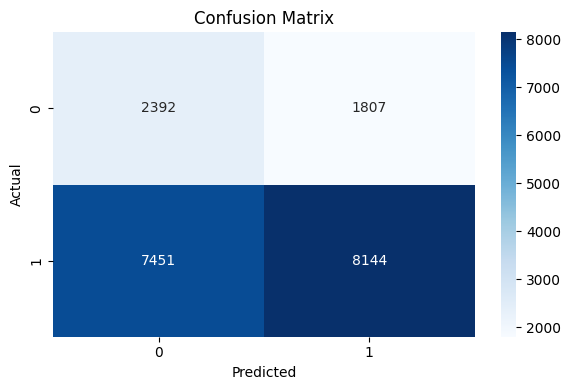

In [57]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()